<a href="https://colab.research.google.com/github/mkpisk/WOE/blob/master/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
USE_G_COLAB = False
if USE_G_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [0]:
if USE_G_COLAB:
    root_dir = "/content/drive/My Drive/CNN/"
    root_dir_to_test = "/content/drive/My\ Drive/CNN/"
    !ls $root_dir_to_test

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


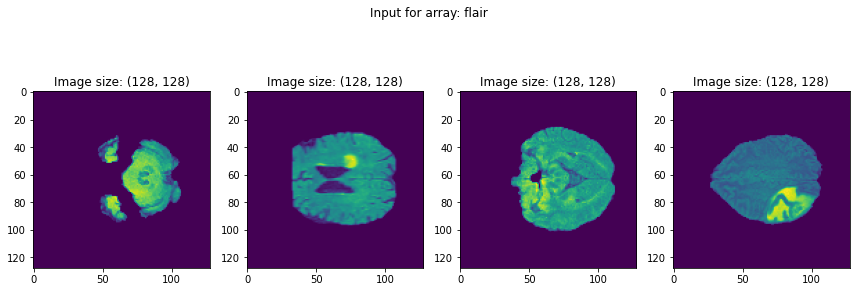

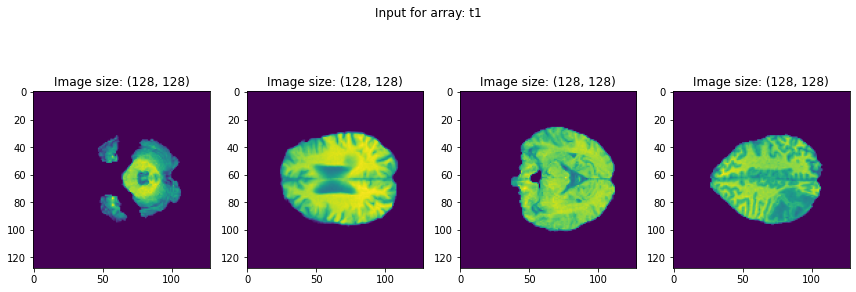

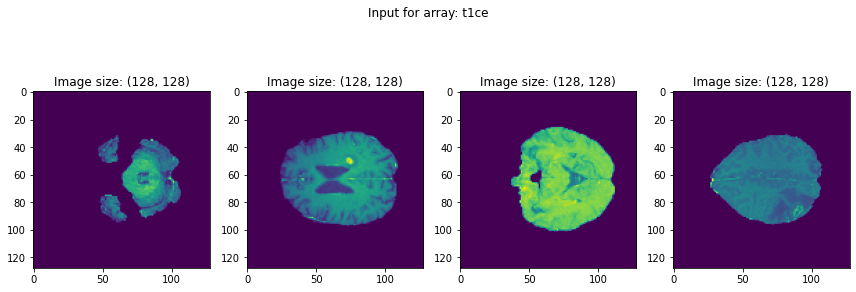

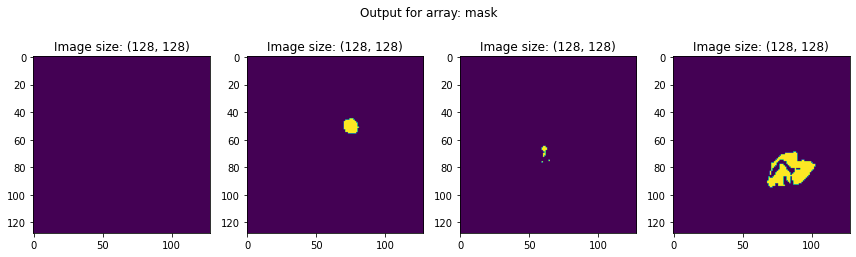

In [0]:
# Import necessary packages for loading the dataset

import numpy as np  # Package for matrix operations, handling data
np.random.seed(2020)
import os
# import cv2
import matplotlib.pyplot as plt  # Package for plotting
#from PIL import Image
# from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.preprocessing.image import load_img
# from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence


class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self,
                 data_path,
                 inputs,
                 outputs,
                 batch_size=32):

        self.data_path = data_path
        self.inputs = inputs
        self.outputs = outputs
        self.batch_size = batch_size

        if data_path is None:
            raise ValueError('The data path is not defined.')

        if not os.path.isdir(data_path):
            raise ValueError('The data path is incorrectly defined.')

        self.file_idx = 0
        self.file_list = [self.data_path + '/' + s
                          for s in os.listdir(self.data_path)]

        self.on_epoch_end()
        with np.load(self.file_list[0]) as npzfile:
            self.out_dims = []
            self.in_dims = []
            self.n_channels = 1

            for i in range(len(self.inputs)):
                im = npzfile[self.inputs[i]]
                self.in_dims.append((self.batch_size,
                                     *np.shape(im),
                                     self.n_channels))

            for i in range(len(self.outputs)):
                im = npzfile[self.outputs[i]]
                self.out_dims.append((self.batch_size,
                                      *np.shape(im),
                                      self.n_channels))

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor((len(self.file_list)) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) *
                               self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.file_list[k] for k in indexes]

        # Generate data
        i, o = self.__data_generation(list_IDs_temp)

        return i, o

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.file_list))
        np.random.shuffle(self.indexes)

    #@threadsafe_generator
    def __data_generation(self, temp_list):
        'Generates data containing batch_size samples'
        # X : (n_samples, *dim, n_channels)
        # Initialization
        inputs = []
        outputs = []

        for i in range(len(self.inputs)):
            inputs.append(np.empty(self.in_dims[i]).astype(np.float32))

        for i in range(self.outputs.__len__()):
            outputs.append(np.empty(self.out_dims[i]).astype(np.float32))

        for i, ID in enumerate(temp_list):
            with np.load(ID) as npzfile:

                for idx in range(len(self.inputs)):
                    x = npzfile[self.inputs[idx]].astype(np.float32)
                    x = x[..., np.newaxis]
                    inputs[idx][i, ...] = x

                for idx in range(len(self.outputs)):
                    x = npzfile[self.outputs[idx]].astype(np.float32)
                    x = x[..., np.newaxis]
                    outputs[idx][i, ...] = x

        return tuple(inputs), tuple(outputs)


gen_dir = "/content/drive/My Drive/CNN/data/"
# gen_dir = "/import/software/3ra023vt20/brats/data/"

# Available arrays in data: 'flair', 't1', 't2', 't1ce', 'mask'
# See the lab instructions for more info about the arrays
input_arrays = ['flair', 't1', 't1ce']
output_arrays = ['mask']
batch_size = 48
gen_train = DataGenerator(data_path=gen_dir + 'training',
                          inputs=input_arrays,
                          outputs=output_arrays,
                          batch_size=batch_size)

# Look at some sample images
img_in, img_out = gen_train[np.random.randint(0, len(gen_train))]
for inp in range(np.shape(img_in)[0]):
    plt.figure(figsize=(12, 5))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(img_in[inp][i, :, :, 0])
        plt.title('Image size: ' + str(np.shape(img_in[inp][i, :, :, 0])))
        plt.tight_layout()
    plt.suptitle('Input for array: ' + gen_train.inputs[inp])
    plt.show()

plt.figure(figsize=(12, 4))
for outp in range(np.shape(img_out)[0]):
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(img_out[outp][i, :, :, 0])
        plt.title('Image size: ' + str(np.shape(img_out[outp][i, :, :, 0])))
        plt.tight_layout()

    plt.suptitle('Output for array: ' + gen_train.outputs[outp])
# import cv2
import matplotlib.pyplot as plt  # Package for plotting
#from PIL import Image
# from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.preprocessing.image import load_img
# from tensorflow.keras.utils import to_categorical    plt.show()

In [0]:
gen_dir = "/content/drive/My Drive/CNN/data/"
input_arrays = ['flair']
output_arrays = ['mask']
batch_size = 48
gen_train = DataGenerator(data_path=gen_dir + 'training',
                          inputs=input_arrays,
                          outputs=output_arrays,
                          batch_size=batch_size)

gen_valid = DataGenerator(data_path=gen_dir + 'validating',
                          inputs=input_arrays,
                          outputs=output_arrays,
                          batch_size=batch_size)

print("#ofFileSamples:", len(gen_train))
print("#ofFileSamples:", len(gen_valid))



#ofFileSamples: 166
#ofFileSamples: 20


In [0]:
import cv2
import matplotlib.pyplot as plt  # Package for plotting
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

In [0]:
import tensorflow.keras as keras

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

#Building the CNN model

inputs = keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))

s = keras.layers.Lambda(lambda x:x / 255)(inputs)
c1 = keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = keras.layers.Dropout(0.1)(c1)
c1 = keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = keras.layers.MaxPool2D((2,2))(c1)

c2 = keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = keras.layers.Dropout(0.1)(c2)
c2 = keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = keras.layers.MaxPool2D((2,2))(c2)

c3 = keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = keras.layers.Dropout(0.1)(c3)
c3 = keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = keras.layers.MaxPool2D((2,2))(c3)

c4 = keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = keras.layers.Dropout(0.1)(c4)
c4 = keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = keras.layers.MaxPool2D((2,2))(c4)

c5 = keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = keras.layers.Dropout(0.1)(c5)
c5 = keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = keras.layers.concatenate([u6, c4])
c6 = keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = keras.layers.Dropout(0.2)(c6)
c6 = keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = keras.layers.concatenate([u7, c3])
c7 = keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = keras.layers.Dropout(0.2)(c7)
c7 = keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = keras.layers.concatenate([u8, c2])
c8 = keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = keras.layers.Dropout(0.2)(c8)
c8 = keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = keras.layers.concatenate([u9, c1])
c9 = keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = keras.layers.Dropout(0.2)(c9)
c9 = keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

model = keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [0]:
#checkpointer = tf.keras.callbacks.ModelCheckpoint('Model_Img_seg.h5', verbose=1, save_best_only=True)

callbacks = [keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
            keras.callbacks.TensorBoard(log_dir='logs')]

In [0]:
nb_train_samples = len(gen_train)
nb_validation_samples = len(gen_train)
nb_validation_samples

166

In [0]:
nb_epoch = 5
nb_train_samples = len(gen_train)
nb_validation_samples = len(gen_train)


results=model.fit_generator(generator=gen_train,
                  epochs=nb_epoch,
                  steps_per_epoch=nb_train_samples,
                  validation_data=gen_valid)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5


AttributeError: ignored

In [0]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape)])